In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import torch_geometric as pyg
import hydra
from hydra.core.global_hydra import GlobalHydra
import os
from typing import Literal
os.environ["HYDRA_FULL_ERROR"] = "1"


from mil.data.mnist import MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, human_format, set_seed
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.models.abmil import WeightedAverageAttention
from mil.models.self_attention import MultiHeadSelfAttention
from mil.models.distance_aware_self_attention import DistanceAwareSelfAttentionHead

RESULTS_FILE = "train.csv"

GlobalHydra().clear()
hydra.initialize(config_path="conf")
cfg = hydra.compose("config.yaml", overrides=["+experiment=mnist_collage", "+model=distance_aware_self_attention"])

set_seed(cfg.seed)

/Users/georg/Projects/mil/mil_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/georg/Projects/mil/mil_env/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/georg/Projects/mil/mil_env/lib/python3.10/site-packages/libpyg.so, 0x0006): Library not loaded: /Users/runner/hostedtoolcache/Python/3.10.8/x64/lib/libpython3.10.dylib
  Referenced from: <F1BD2198-1C99-32D8-AC2F-5EDD02B6524B> /Users/georg/Projects/mil/mil_env/lib/python3.10/site-packages/libpyg.so
  Reason: tried: '/Users/runner/hostedtoolcache/Python/3.10.8/x64/lib/libpython3.10.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/runner/hostedtoolcache/Python/3.10.8/x64/lib/libpython3.10.dylib' (no such file), '/

# MNIST bags / MNIST collage

This notebook trains models on variations of the _mnist-bags_, _multi-mnist-bags_, and _mnist-collage_ datasets.
The goal of this notebook is to see which models are able to overfit on these datasets.

The following cell defines three variables, `DATASET`, `TARGET_NUMBERS` and `MODEL` which can be used to run different dataset/model configurations.

`DATASET`:

- `OneHotMNISTBags`: one-hot version of _mnist-bags_, where the dataset yields 10-dimensional one-hot encoded feature vectors directly (i.e. we are not yet working with MNIST digits)
- `MNISTBags`: the _mnist-bags_ dataset
- `OneHotMNISTCollage`: one-hot version of _mnist-collage_
- `MNISTCollage`: _mnist-collage_ dataset

`TARGET_NUMBERS`:

- `0` corresponds to the _mnist-bags_ dataset
- `(0, 1)` corresponds to the _multi-mnist-bags_ dataset

`MODELS`:

- `"mean_pool"`: simple baseline that uses mean pooling. Works neither dataset.
- `"max_pool"`: simple baseline that uses max pooling. Works for _mnist-bags_, but not _multi-mnist-bags_.
- `"weighted_average_attention"`: uses attention mechanism from "Attention Based Deep Multiple Instance Learning" paper which can only "focus" on one target number at a time. Works for _mnist-bags_, but not _multi-mnist-bags_.
- `"self_attention_mean_pooling"`: uses a single transformer layer (self attention) followed by mean pooling. Works for both datasets.
- `"self_attention_max_pooling"`: uses a single transformer layer (self attention) followed by max pooling. Works for both datasets (but better than mean pooling).

Try changing `DATASET`, `TARGET_NUMBERS` and `MODELS` below and rerunning the notebook.


In [81]:
datasets = {"train": hydra.utils.instantiate(cfg.dataset.train), "test": hydra.utils.instantiate(cfg.dataset.test)}


def make_data_loader(train: bool = True):
    """Utility function to create a data loader for the dataset."""
    ds = datasets["train" if train else "test"]
    return torch.utils.data.DataLoader(ds, batch_size=1, shuffle=train, collate_fn=lambda x: x[0], num_workers=0)

## Define the model

The three parts of the MIL model are:

1. **feature extractor**: extract a feature vector $z \in \mathbb{R}^D$ from each instance. In the case of the one-hot dataset, this is just the identity function. For the actual _mnist-bags_ dataset, this is a CNN.
2. **pooling**: a function $f : \mathbb{R}^{N \times D} \to \mathbb{R}^D$ that aggregates the $N$ feature vectors in the bag to a single feature vector.
3. **classifier**: a function $g : \mathbb{R}^D \to \mathbb{R}$ that transforms the aggregated feature vector into a binary classification prediction (we parameterise $g$ using a linear layer followed by a sigmoid)


In [82]:
model = hydra.utils.instantiate(cfg.model, _convert_="partial")

### Local development

We'll override `model.pooler` here to facilitate quick development in the notebook


In [87]:
from mil.models.relative import DistanceAwareMultiheadAttention

att = DistanceAwareMultiheadAttention(
    embed_dim=32,
    num_heads=1,
    dropout=0.1,
    bias=False,
    kdim=None,
    vdim=None,
    batch_first=True,
    add_zero_attn=True,
    # Custom arguments for relative positional encoding
    embed_keys=False,
    embed_queries=True,
    embed_values=False,
    emb_dropout=0.1,  # TODO: test with dropout
)

model.pooler = att

In [88]:
import pytorch_lightning as pl
from functools import partial
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pathlib import Path


class LitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = nn.BCEWithLogitsLoss()
        self.forward = self.model.forward
        self.training_step = partial(self.step, phase="train")
        self.validation_step = partial(self.step, phase="val")
        self.test_step = partial(self.step, phase="test")

    @classmethod
    def accuracy_score(cls, y_pred, y):
        return ((y_pred > 0.5).float() == y).cpu().detach().float()

    def step(self, bag, batch_idx, phase: Literal["train", "val", "test"]):
        y_pred, y_logit = model(bag)
        y_pred = y_pred.squeeze()
        loss = self.loss(y_logit, bag.y)

        self.log(f"{phase}_loss", loss.detach(),
                 on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"{phase}_acc", self.accuracy_score(y_pred, bag.y),
                 on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=1e-3, weight_decay=1e-4)
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=1e-3, weight_decay=1e-2)
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=1e-4, weight_decay=1e-2)
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        #     optimizer, T_max=cfg.num_epochs)
        # return [optimizer], [scheduler]
        return optimizer


lit_model = LitModel(model)
csv_logger = CSVLogger("logs")

trainer = pl.Trainer(max_epochs=100, logger=csv_logger,
                     callbacks=[TQDMProgressBar(refresh_rate=50)])
trainer.fit(lit_model, make_data_loader(
    train=True), make_data_loader(train=False))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MILModel          | 18.7 K
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
18.7 K    Trainable params
0         Non-trainable params
18.7 K    Total params
0.075     Total estimated model params size (MB)


Epoch 50:  83%|████████▎ | 250/300 [00:01<00:00, 131.81it/s, v_num=5, val_loss=0.045, val_acc=0.990, train_loss=0.0732, train_acc=0.977] 

<Axes: xlabel='Epoch', ylabel='Accuracy'>

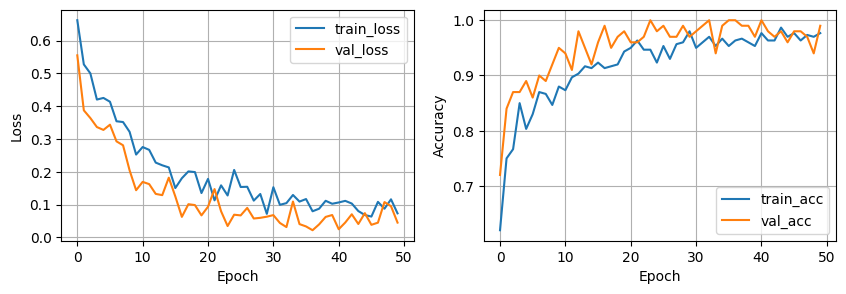

In [89]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

plt.figure(figsize=(10, 3))
plt.subplot(121)
df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss", ax=plt.gca())

plt.subplot(122)
df_metrics[["train_acc", "val_acc"]].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy", ax=plt.gca())

## Test


In [90]:
test_ds = datasets["test"]

predictions = trainer.predict(lit_model, test_ds)
predictions = [(bag, x[0]) for bag, x in zip(test_ds, predictions)]

print_prediction_stats(
    predictions, target_numbers=cfg.settings.mnist.target_numbers)

Predicting DataLoader 0: 100%|██████████| 100/100 [00:00<00:00, 305.48it/s]

                                 % acc    total    -pred    +pred     example
  bags                              99      100       49       51     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags with 0s                      98       78       27       51     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags without 0s                  100       22       22        0     5 4 5 8 4 5 4 9 2 3 2 9 7
  bags with 0s and 1s               98       62       11       51     9 1 9 2 0 4 0 7 2 0
  bags with 0s and not 1s          100       16       16        0     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags with 0s or 1s                98       94       43       51     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags with 1s                      98       78       27       51     9 1 9 2 0 4 0 7 2 0
  bags without 1s                  100       22       22        0     6 2 2 4 8 4 4 9 3 9 9 9 0 2
  bags with 1s and 0s               98       62       11       51     9 1 9 2 0

### First 10 bags in test dataset


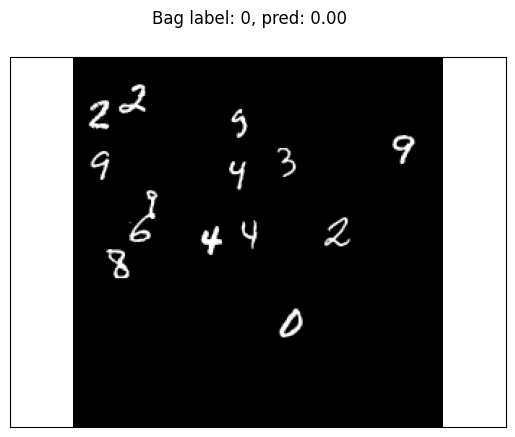

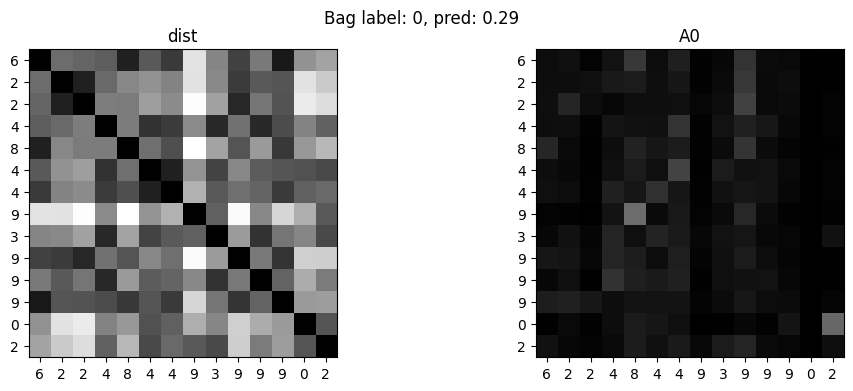

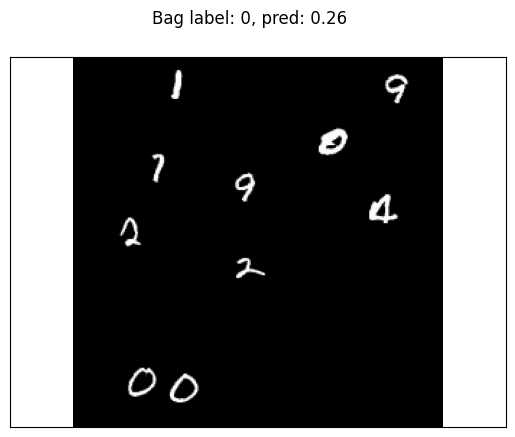

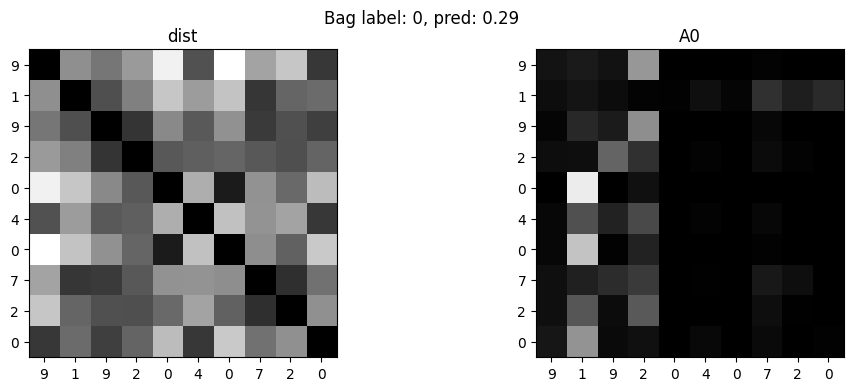

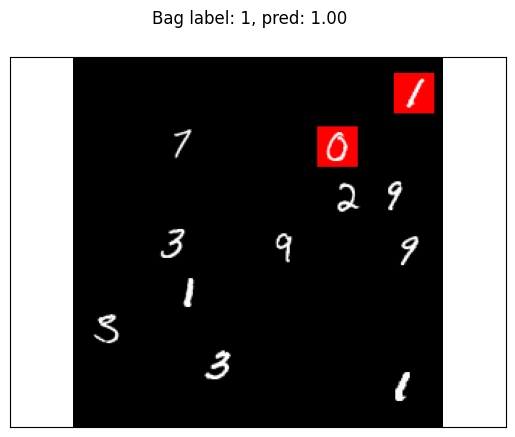

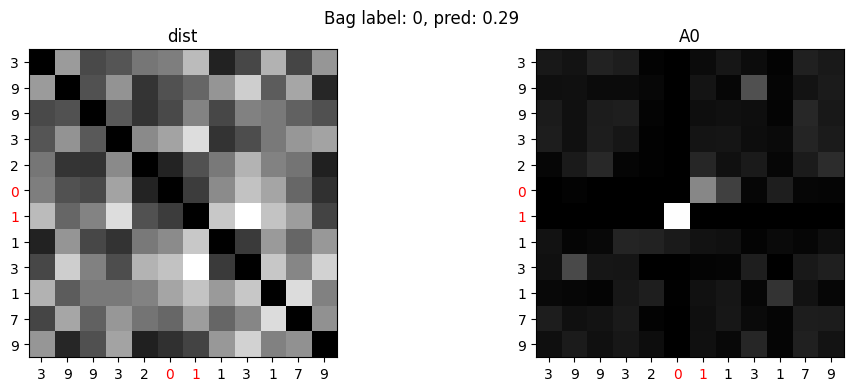

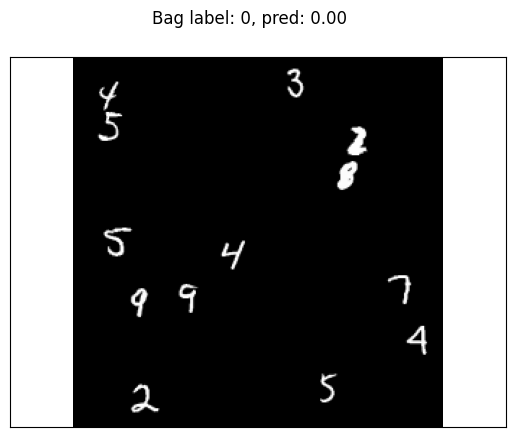

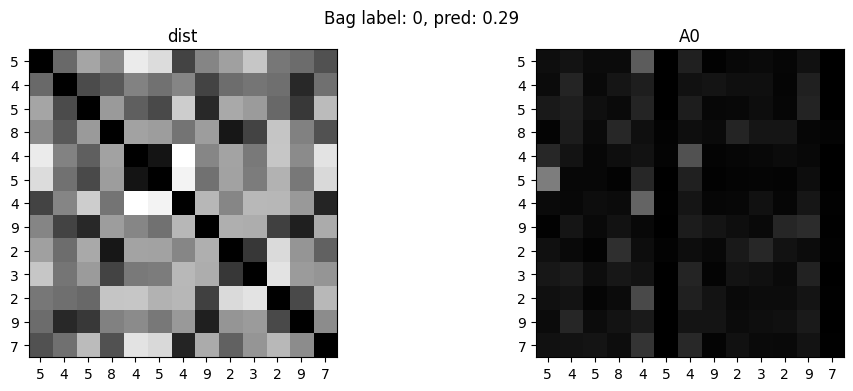

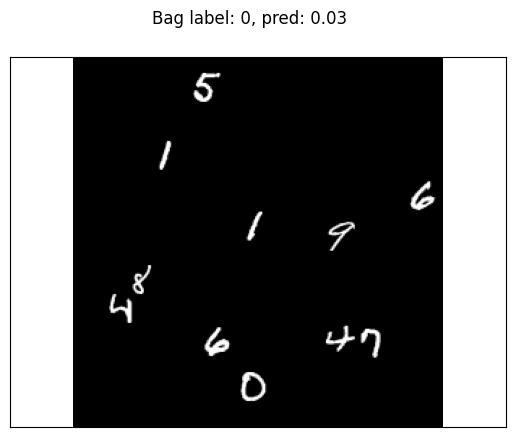

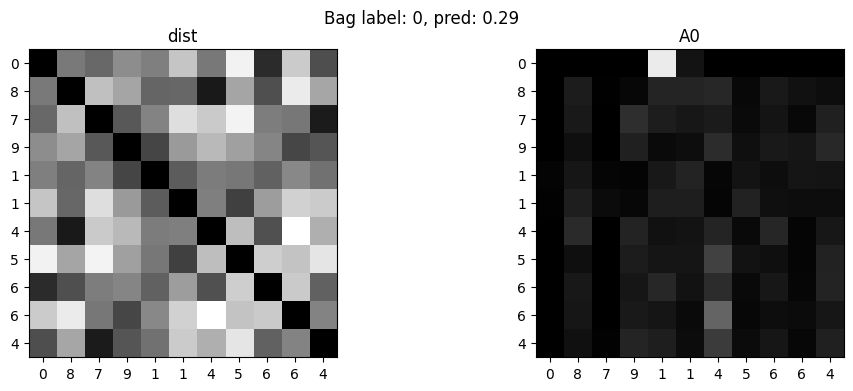

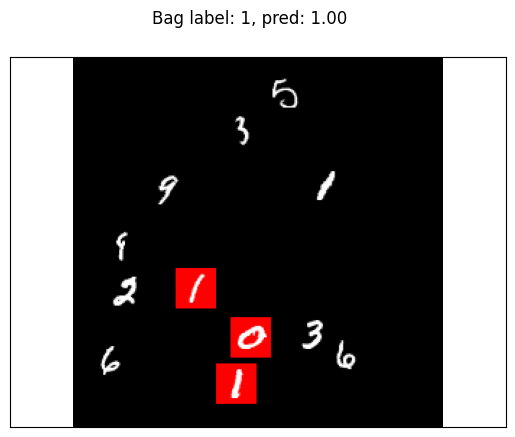

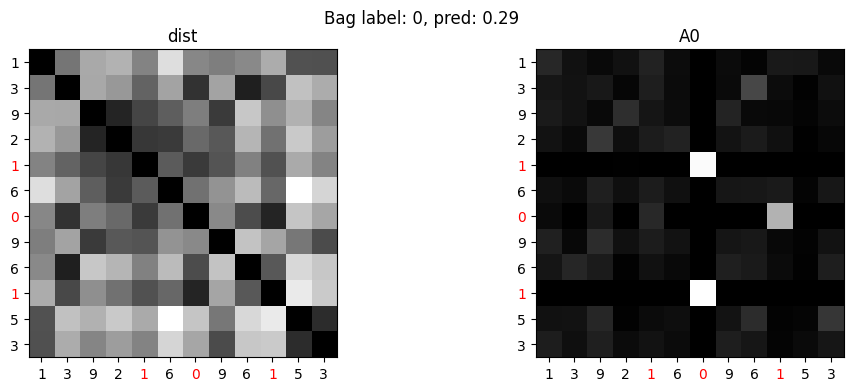

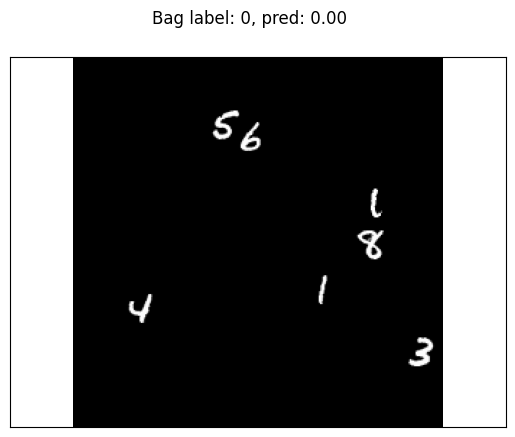

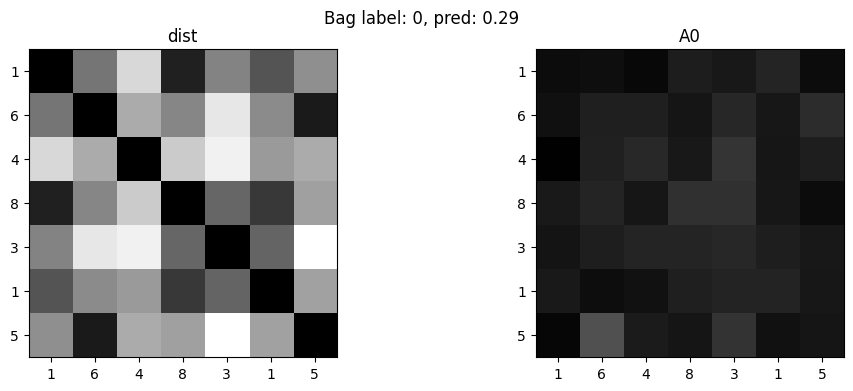

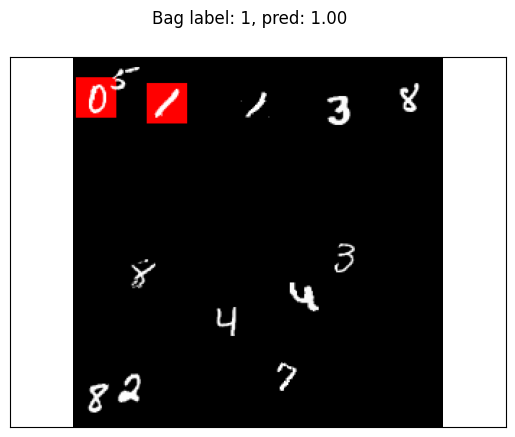

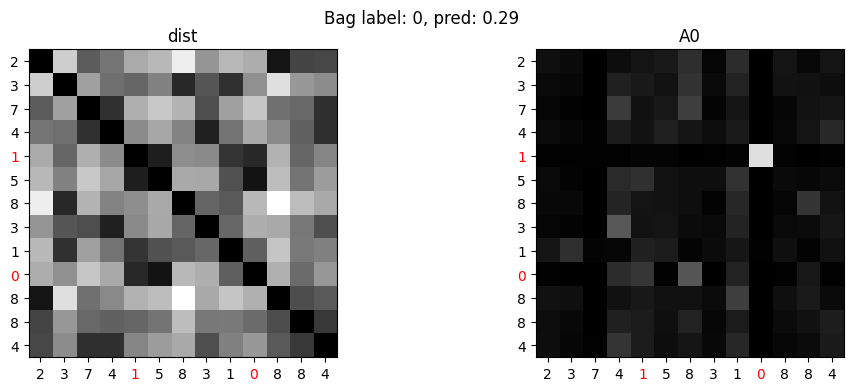

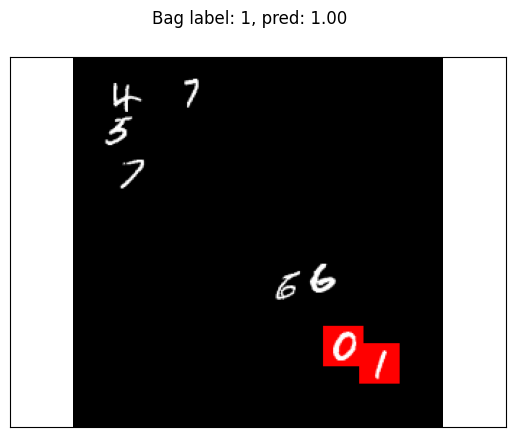

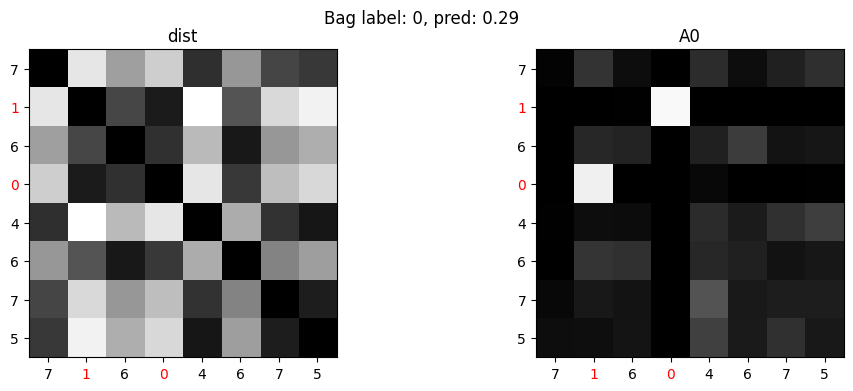

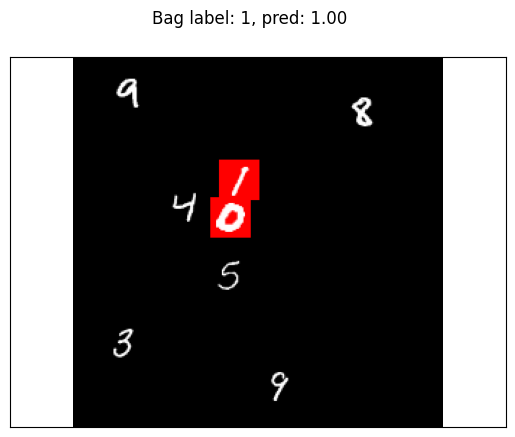

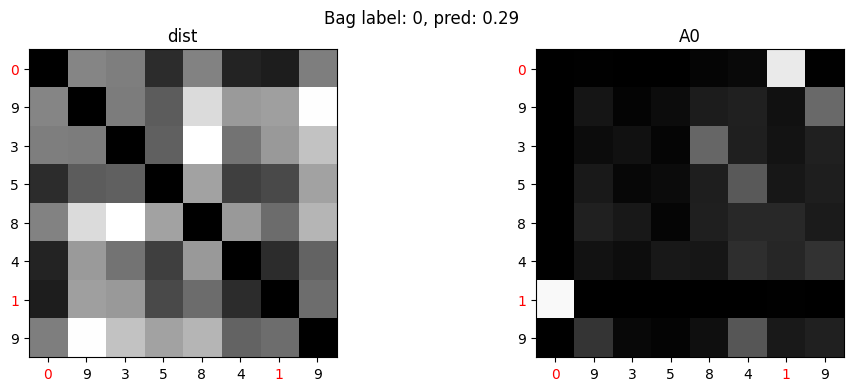

In [91]:
attention_layer = model.pooler


class Hook:
    def __init__(self, m: nn.Module):
        self.hook = m.register_forward_hook(self.hook_fn)
        self.input = None
        self.output = None

    def hook_fn(self, module, input, output):
        self.input = self._detach(input)
        self.output = self._detach(output)

    @classmethod
    def _detach(cls, x):
        if isinstance(x, (tuple, list)):
            return type(x)(cls._detach(y) for y in x)
        elif isinstance(x, dict):
            return {k: cls._detach(v) for k, v in x.items()}
        else:
            return x.detach()

    def close(self):
        self.hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()


def plot_dist_aware_attention(bag, edge_index, edge_attr, num_nodes):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
    A = attention_layer.attention[0]
    num_heads = A.shape[0]
    plt.subplot(1, num_heads + 1, 1)
    plt.title("dist")
    dist = pyg.utils.to_dense_adj(edge_index, edge_attr=edge_attr.squeeze(-1), max_num_nodes=num_nodes).squeeze(
        0
    )  # NxN
    plot_attention_head(bag, dist, limit_range=False)
    for i in range(num_heads):
        plt.subplot(1, num_heads + 1, i + 2)
        plt.title(f"A{i}")
        plot_attention_head(bag, A[i])


def visualize_prediction(bag):
    y = bag.y

    with Hook(attention_layer) as hook:
        y_pred, _ = model(bag)
        y_pred = y_pred.squeeze(0)
    features, edge_index, edge_attr, *_ = hook.input

    if isinstance(datasets["test"], OneHotMNISTBags):
        if isinstance(attention_layer, WeightedAverageAttention):
            print_one_hot_bag_with_attention(
                bag, attention_layer.A, y_pred > 0.5)
            print()
        elif isinstance(attention_layer, MultiHeadAttention):
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            print_one_hot_bag(bag, y_pred > 0.5)
    elif isinstance(datasets["test"], MNISTBags):
        if isinstance(attention_layer, WeightedAverageAttention):
            plot_bag(bag, y_pred=y_pred,
                     attention=attention_layer.A.squeeze(-1))
        elif isinstance(attention_layer, MultiHeadAttention):
            plot_bag(bag, y_pred=y_pred)
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            plot_bag(bag, y_pred=y_pred)
    elif isinstance(datasets["test"], OneHotMNISTCollage):
        plt.figure()
        plot_one_hot_collage(bag, y_pred=y_pred)
        plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        if isinstance(attention_layer, DistanceAwareSelfAttentionHead):
            plot_dist_aware_attention(bag)
    elif isinstance(datasets["test"], MNISTCollage):
        plot_bag(bag, y_pred=y_pred, collage_size=cfg.dataset.test.collage_size)
        if isinstance(model.pooler, DistanceAwareSelfAttentionHead) or True:
            plot_dist_aware_attention(
                bag, edge_index=edge_index, edge_attr=edge_attr, num_nodes=features.shape[0])


# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(make_data_loader(train=False), 10):
        bag = device(bag)
        visualize_prediction(bag)

### First 10 mistakes in test dataset


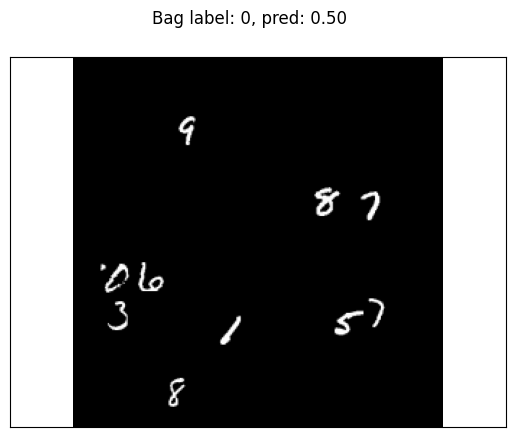

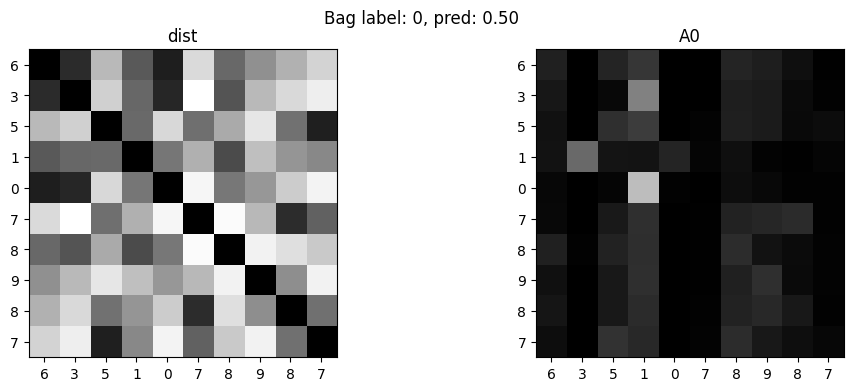

In [92]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in make_data_loader(train=False):
        if i == 10:
            break
        bag = device(bag)
        y = bag.y.float()
        y_pred, _ = model(bag)
        y_pred = y_pred.squeeze(0)
        if ((y_pred > 0.5).float() != y).cpu().detach():
            visualize_prediction(bag)
            i += 1